# Load modules

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image

# Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

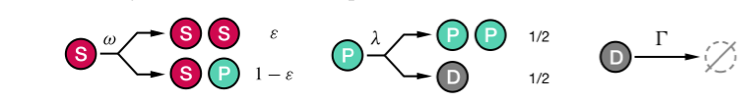

In [2]:
Image("cell_division.png")


In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 = omega * epsilon
    Reaction 2: S > S + P,    rate of reaction k2 = omega * (1 - epsilon)
    Reaction 3: P > P + P,    rate of reaction k3 = lambda * 0.5
    Reaction 4: P > D,        rate of reaction k4 = lambda * 0.5
    Reaction 5: D > none,     rate of reaction k5 = gamma
    
For each simulation, 
    
    1. the propensity function for each reaction is calculated based of the number reactant cells (S, P, D) in the population and the rate of reaction;
    2. a first random number is generated to decide time for next reaction;
    3. a second random number is generated to decide which reaction occurs next;
    4. as the reaction occurs, the number of cells (reactant and product) in the population is updated.

# Cell composition at primary injection

In Lan et al.'s study, they started primary passage with a single labelled stem (S) cell or progenitor (P) cell, each with a probability that reflects the steady-state fractions. Then during serial passage, about 5% of the harvesting cells are chosen for reinjection. These reinjected cells consist of stem cells and progenitor cell since differentiated cells were unlikely to survive during the process of serial transplantation. 

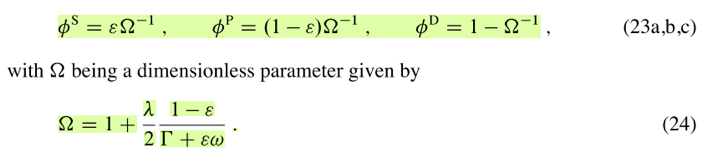

In [3]:
Image("SPD.png")

In [4]:
def stationaryCellComposition(parameters):
    Omega = parameters["stem_div_rate"]
    Epsilon = parameters["epsilon"]
    Lambda = parameters["pro_div_rate"]
    Gamma = parameters["apoptosis_rate"]
    Ome = 1 + 0.5 * Lambda * (1 - Epsilon) / (Gamma + Epsilon * Omega)
    # stem cell
    S = Epsilon / Ome
    # progenitor cell
    P = (1 - Epsilon) / Ome
    # differentiated cell
    # D = 1 - (S + P)
    return{"stem":S, "progenitor":P}

parameters = {
    "stem_div_rate":0.15,
    "epsilon":0.15,
    "pro_div_rate":1.0,
    "apoptosis_rate":0.48}

stemPrimaryProb = stationaryCellComposition(parameters)["stem"]/(stationaryCellComposition(parameters)["stem"]+stationaryCellComposition(parameters)["progenitor"])
print(stemPrimaryProb)

0.15


Also following equation was used to determin the percentage of cells for reinjection through serial pasages.

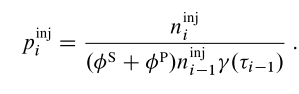

In [5]:
Image("reinjection.png")

In [6]:
def transplantationProb(parameters,n,meanExpansion):
    S = stationaryCellComposition(parameters)["stem"]
    P = stationaryCellComposition(parameters)["progenitor"]
    prob = n/((S + P) * meanExpansion)
    return(prob)

transplantationProb = transplantationProb(parameters,2,10)
print(transplantationProb)

0.3691542288557214


# Clonal growth simulation

In [7]:
def cellCount(reactionTime, cell, countingTimePoint):
    time = range(countingTimePoint)
    count = np.zeros(len(time))
    for t in time:
        cellIndex = np.array(np.where(reactionTime <= t)[0])
        if cellIndex.size:
            cellTimeIndex = np.array(cellIndex[-1])
            count[t] = cell[cellTimeIndex]
        else:
            count[t] = cell[0]
    return(count)

def passageClonalGrowth(inject, parameters, countingTimePoint):
    stemDivRate = parameters["stem_div_rate"]
    epsilon = parameters["epsilon"]
    proDivRate = parameters["pro_div_rate"]
    apoptosisRate = parameters["apoptosis_rate"]
    countingTimePoint = countingTimePoint
    S = np.array([inject["stem"]])
    P = np.array([inject["progenitor"]])
    D = np.array([0])
    reactionTime = np.array([0])    
#     Reaction 1: S > S + S, rate of reaction (k1) = stemDivRate * epsilon
    k1 = stemDivRate*epsilon
#     Reaction 2: S > S + P, rate of reaction (k2) = stemDivRate * (1 - epsilon)
    k2 = stemDivRate*(1-epsilon)        
#     Reaction 3: P > P + P, rate of reaction (k3) = proDivRate * 0.5
    k3 = proDivRate*0.5    
#     Reaction 4: P > D, rate of reaction (k4) = proDivRate * 0.5
    k4 = proDivRate*0.5    
#     Reaction 5: D > none, rate of reaction (k5) = apoptosisRate
    k5 = apoptosisRate    
    cont = True  
    while(cont):
#         Reaction 1: propensity function (A1) = S(t) * k1
        A1 = S[-1]*k1
#         Reaction 2: propensity function (A2) = S(t) * k2
        A2 = S[-1]*k2    
#         Reaction 3: propensity function (A3) = P(t) * k3
        A3 = P[-1]*k3
#         Reaction 4: propensity function (A4) = P(t) * k4
        A4 = P[-1]*k4
#         Reaction 5: propensity function (A5) = D(t) * k5
        A5 = D[-1]*k5
        A0 = A1 + A2 + A3 + A4 + A5
#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime[-1] + t > countingTimePoint:
            cont = False
        else:
            reactionTime = np.append(reactionTime,reactionTime[-1] + t)
#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S = np.append(S, S[-1]+1)
                P = np.append(P, P[-1])
                D = np.append(D, D[-1])
            elif r2 < (A1+A2+A3)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]+1)
                D = np.append(D, D[-1])
            elif r2 < (A1+A2+A3+A4)/A0:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1]-1)
                D = np.append(D, D[-1]+1)
            else:
                S = np.append(S, S[-1])
                P = np.append(P, P[-1])
                D = np.append(D, D[-1]-1)
    stem = cellCount(reactionTime, S, countingTimePoint)
    pro = cellCount(reactionTime, P, countingTimePoint)
    diff = cellCount(reactionTime, D, countingTimePoint)
#     print('final reaction time = ' + str(reactionTime[-1]))
#     print('final clone size = ' + str(N[-1]))
    return{"stem":stem,"progenitor":pro,"differentiated":diff}

def transplantation(harvest,transplantationProb):
    stemHarvest = harvest["stem"][-1]
    proHarvest = harvest["progenitor"][-1] 
    totalHarvest = stemHarvest + proHarvest
#    only stem cells and progenitor cells may survive during the process of serial transplantation. 
    if totalHarvest > 0:
        stemProb = stemHarvest/totalHarvest
        proProb = proHarvest/totalHarvest
        stemReinject = np.random.binomial(n=totalHarvest, p=stemProb*transplantationProb)
        proReinject = np.random.binomial(n=totalHarvest, p=proProb*transplantationProb)
    else:
        stemReinject = 0
        proReinject = 0
    return{"stem":np.array([stemReinject]), "progenitor":np.array([proReinject]), "differentiated":np.array([0])}

def passageExpansion(primaryInject, parameters, countingTimePoint, transplantationProb, seed):
    np.random.seed(seed)
    primaryHarvest = passageClonalGrowth(primaryInject, parameters,countingTimePoint[0])
    secondaryInject = transplantation(primaryHarvest, transplantationProb)
    secondaryHarvest = passageClonalGrowth(secondaryInject, parameters,countingTimePoint[1])
    tertiaryInject = transplantation(secondaryHarvest, transplantationProb)
    tertiaryHarvest = passageClonalGrowth(tertiaryInject, parameters,countingTimePoint[2])
    S = np.concatenate((primaryHarvest["stem"],secondaryHarvest["stem"],tertiaryHarvest["stem"]))
    P = np.concatenate((primaryHarvest["progenitor"],secondaryHarvest["progenitor"],tertiaryHarvest["progenitor"]))
    D = np.concatenate((primaryHarvest["differentiated"],secondaryHarvest["differentiated"],tertiaryHarvest["differentiated"]))
    return{"stem":S, "progenitor":P, "differentiated":D}

def cellExpansionPlot(harvest):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    x = range(len(S))
    plt.plot(x,S,label='stem cell')
    plt.plot(x,P,label='progenitor cell')
    plt.plot(x,D,label='differentiated cell')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('cell count')

def checkSteadyPlot(harvest):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    total = np.array([sum((s,p,d)) for (s,p,d) in zip(S, P, D)])
    x = range(len(S))
    plt.plot(x,S/total,label='stem cell')
    plt.plot(x,P/total,label='progenitor cell')
    plt.plot(x,D/total,label='differentiated cell')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('cell composition')
    
def cloneGrowthPlot(harvest):
    S = harvest["stem"]
    P = harvest["progenitor"]
    D = harvest["differentiated"]
    total = np.array([sum((s,p,d)) for (s,p,d) in zip(S, P, D)])
    x = range(len(S))
    plt.plot(x,total)
    plt.xlabel('time')
    plt.ylabel('clone size')

CPU times: user 7.96 ms, sys: 1.02 ms, total: 8.98 ms
Wall time: 11.7 ms


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


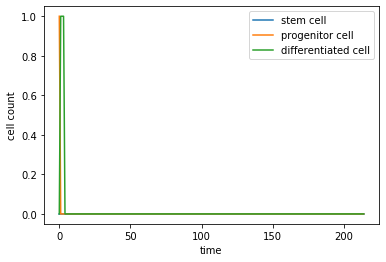

In [8]:
countingTimePoint = np.array([80, 65, 70])

stemPrimary = np.random.binomial(n=1, p=stemPrimaryProb)
primaryInject = {
    "stem":stemPrimary,
    "progenitor":1-stemPrimary}

%time fullPassage = passageExpansion(primaryInject, parameters, countingTimePoint, transplantationProb, 0)
cellExpansionPlot(fullPassage)

# Clonal growth simulation for multiple clones

In [9]:
def multiGrowthSimulation(seed):
    # N: the number of parallele tasks   
    simulation = 10000
    np.random.seed(seed)
    s = np.random.binomial(n=simulation, p=stemPrimaryProb)
    timeRange = int(sum(countingTimePoint))
    multiGrowth = np.zeros((simulation,3,timeRange))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0}, parameters, countingTimePoint, transplantationProb, seed*simulation+i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":1}, parameters, countingTimePoint, transplantationProb, seed*simulation+i)
        multiGrowth[i][0][:] = clone["stem"]
        multiGrowth[i][1][:] = clone["progenitor"]
        multiGrowth[i][2][:] = clone["differentiated"]
    return(multiGrowth)
        
def multiGrowthPlot(multiGrowth):
    x= range(np.shape(multiGrowth)[2])
    for clone in multiGrowth:
        plt.plot(x,clone[0],'b')
        plt.plot(x,clone[1],'r')
        plt.plot(x,clone[2],'g')    
    plt.xlabel('time')
    plt.ylabel('cell count')
    
def meanGrowth(multiGrowth, countingTimePoint):
    shape = np.shape(multiGrowth)
    stem = np.zeros((shape[0],shape[2]))
    pro = np.zeros((shape[0],shape[2]))
    diff = np.zeros((shape[0],shape[2]))
    for i in range(shape[0]):
        stem[i][:] = multiGrowth[i][0]
        pro[i][:] = multiGrowth[i][1]
        diff[i][:] = multiGrowth[i][2]
    S = np.transpose(stem)
    P = np.transpose(pro)
    D = np.transpose(diff)
    meanS = np.array([np.mean(s) for s in S])
    sHarvest = meanS[np.cumsum(countingTimePoint)-1]
    meanP = np.array([np.mean(p) for p in P])
    pHarvest = meanP[np.cumsum(countingTimePoint)-1]
    meanD = np.array([np.mean(d) for d in D])
    dHarvest = meanD[np.cumsum(countingTimePoint)-1]
    print([sum((s,p,d)) for (s,p,d) in zip(sHarvest, pHarvest,dHarvest)])
    return{"stem":meanS, "progenitor":meanP, "differentiated":meanD}

def cloneSizeDistribution(multiGrowth, countingTimePoint):
    clones = len(multiGrowth)
    primary = np.zeros(clones)
    secondary = np.zeros(clones)
    tertiary = np.zeros(clones)
    for clone in range(clones):
        primary[clone] = sum(np.array([multiGrowth[clone][cellType][int(countingTimePoint[0]-1)] for cellType in range(3)]))
        secondary[clone] = sum(np.array([multiGrowth[clone][cellType][int(sum(countingTimePoint[:1])-1)] for cellType in range(3)]))
        tertiary[clone] = sum(np.array([multiGrowth[clone][cellType][int(sum(countingTimePoint[:2])-1)] for cellType in range(3)]))
    return{"primary":primary, "secondary":secondary, "tertiary": tertiary}


In [10]:
%time multiGrowth = multiGrowthSimulation(2)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 22min 41s, sys: 16.6 s, total: 22min 58s
Wall time: 23min 58s


In [11]:
np.shape(multiGrowth)

(10000, 3, 215)

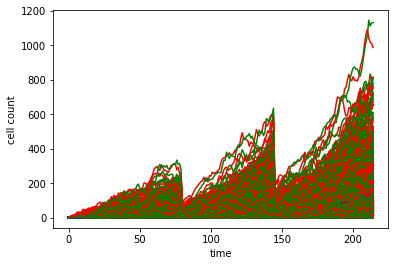

In [12]:
multiGrowthPlot(multiGrowth)

[11.517800000000001, 18.5136, 31.3808]
CPU times: user 138 ms, sys: 102 ms, total: 240 ms
Wall time: 336 ms


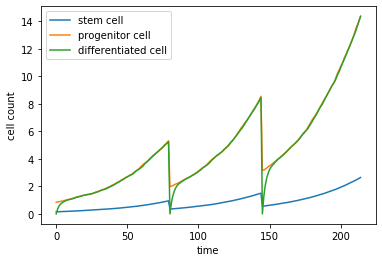

In [13]:
%time averageGrowth = meanGrowth(multiGrowth, countingTimePoint)
cellExpansionPlot(averageGrowth)

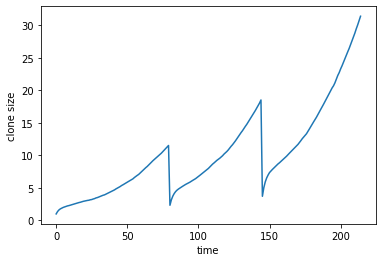

In [14]:
cloneGrowthPlot(averageGrowth)

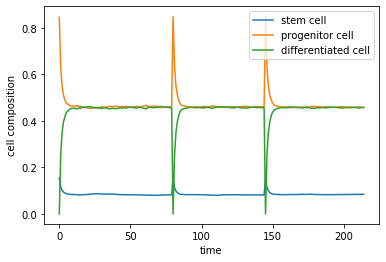

In [15]:
checkSteadyPlot(averageGrowth)

CPU times: user 446 ms, sys: 5.1 ms, total: 451 ms
Wall time: 454 ms


(array([9.32e+03, 3.22e+02, 1.84e+02, 8.50e+01, 4.70e+01, 1.90e+01,
        1.20e+01, 8.00e+00, 1.00e+00, 2.00e+00]),
 array([  0. ,  55.4, 110.8, 166.2, 221.6, 277. , 332.4, 387.8, 443.2,
        498.6, 554. ]),
 <a list of 10 Patch objects>)

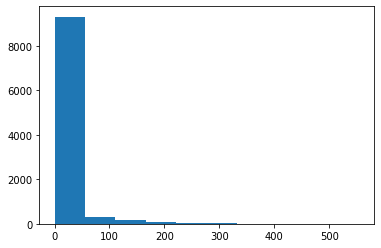

In [16]:
%time cloneSize = cloneSizeDistribution(multiGrowth, countingTimePoint)
plt.hist(cloneSize["primary"])

In [17]:
print("average clone size at primary harvest = "+str(np.mean(cloneSize["primary"])))
print("average clone size at secondary harvest = "+str(np.mean(cloneSize["secondary"])))
print("average clone size at tertiary harvest = "+str(np.mean(cloneSize["tertiary"])))

average clone size at primary harvest = 11.5178
average clone size at secondary harvest = 11.5178
average clone size at tertiary harvest = 18.5136


(array([9.32e+03, 3.22e+02, 1.84e+02, 8.50e+01, 4.70e+01, 1.90e+01,
        1.20e+01, 8.00e+00, 1.00e+00, 2.00e+00]),
 array([  0. ,  55.4, 110.8, 166.2, 221.6, 277. , 332.4, 387.8, 443.2,
        498.6, 554. ]),
 <a list of 10 Patch objects>)

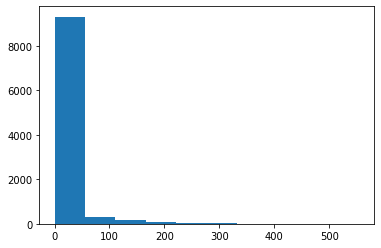

In [18]:
plt.hist(cloneSize["secondary"])

(array([9.492e+03, 2.700e+02, 1.260e+02, 6.000e+01, 2.900e+01, 1.000e+01,
        7.000e+00, 2.000e+00, 1.000e+00, 3.000e+00]),
 array([   0. ,  124.8,  249.6,  374.4,  499.2,  624. ,  748.8,  873.6,
         998.4, 1123.2, 1248. ]),
 <a list of 10 Patch objects>)

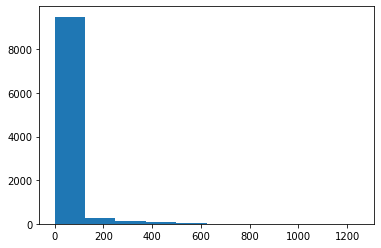

In [19]:
plt.hist(cloneSize["tertiary"])

## Negative Binomial Distribution

In Lan et al.'s experiments, the sizes of the tumour clones showed a negative binomial distribution (NBD). Therefore, the fitness of the simulated data to NBD is also checked.In order to detect the NBD of clone sizes, first incomplete moment (FIM) was also applied. By definition, FIM gives the relative average clone size of all clones with sizes larger than n.

In [20]:
def negativeBinomialDistribution(divisionRate, countingTimePoint, n):
    n0 = divisionRate * countingTimePoint / 2
    N0 = np.log(n0)
    P = 1 / N0 * np.exp(-n/n0) / n
    return(P)

def logSizeDistribution(cloneSizes,NBD):
    minimum = int(min(cloneSizes))
    print('minimum clone size = ' + str(minimum))
    maximum = int(max(cloneSizes))
    print('maximum clone size = ' + str(maximum))
    x = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    plt.bar(x,np.log(freq),width=2,color='y') 
    plt.plot(x, np.log(len(cloneSizes)*NBD), 'r')
    plt.ylim((0, 5))
    plt.xlabel('clone size')
    plt.ylabel('log frequency')

def firstIncompleteMoment(cloneSizes):
    maximum = int(max(cloneSizes))
    cloneSizeRange = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i) for i in range(maximum+1)])
    prob = freq/sum(freq)
    averageCloneSize = np.mean(cloneSizes)
    step1 = np.array([i*p for (i,p) in enumerate(prob)])
    step4 = np.zeros(len(step1))
    for i in range(len(step1)):
        step4[i]= sum(step1[i:-1])
    mu = step4/averageCloneSize
    return(mu)

# def firstIncompleteMoment(cloneSizes):
#     maximum = int(max(cloneSizes))
# # here we count the clone size of zero
#     prob = np.histogram(cloneSize, bins=range(maximum),density=True)
#     averageCloneSize = np.mean(cloneSizes)
#     singleSizeDistribution = np.array([i*p for (i,p) in enumerate(prob)])
#     multiSizeDistribution = np.zeros(len(singelSizeDistribution))
#     for n in range(len(singleSizeDistribution)):
#         multiSizeDistribution[i] = sum(singleSizeDistribution[i:-1]) 
#     mu = multiSizeDistribtion/averageCloneSize
#     return(mu)

def logScalePlot(X,y):
#     Y = np.log(y)
    plt.plot(X,y,'b')
#     plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),'r')
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')
    plt.yscale('log')

In [21]:
# testingCloneSizeRange = np.asarray(range(int(max(testingCloneSizes))))
# testingNBD = negativeBinomialDistribution(divisionRate=1, countingTimePoint=80, n=testingCloneSizeRange)
# %time logSizeDistribution(testingCloneSizes,testingNBD)

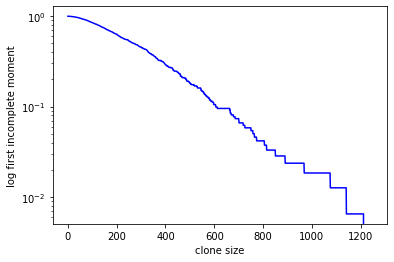

In [22]:
testing = cloneSize["tertiary"]
testingRange = np.asarray(range(int(max(testing)+1)))
mu = firstIncompleteMoment(testing)
logScalePlot(testingRange,mu)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


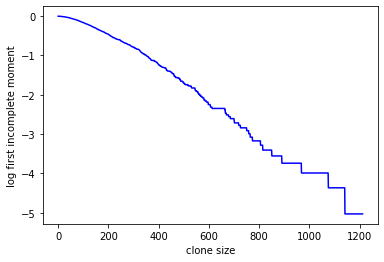

In [23]:
def logSizePlot(X,y):
    Y = np.log(y)
    plt.plot(X,Y,'b')
    plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)),'r')
    plt.xlabel('clone size')
    plt.ylabel('log first incomplete moment')

logSizePlot(testingRange,mu)

# Parallel simulation

In [24]:
# if __name__ == '__main__':
#     with Pool(8) as p:
#         %time result = p.map(multiGrowthSimulation, range(10))

# parallelGrowth = np.concatenate(result)
# np.shape(parallelGrowth)

In [25]:
# %time multiGrowthPlot(parallelGrowth)

In [26]:
# %time averageParallelGrowth = meanGrowth(parallelGrowth)
# cellExpansionPlot(averageParallelGrowth)

In [27]:
# %time parallelCloneSize = cloneSizeDistribution(multiGrowth, countingTimePoint)
# print("average clone size at primary harvest = "+str(np.mean(parallelCloneSize["primary"])))
# plt.hist(parallelCloneSize["primary"])

In [28]:
# print("average clone size at secondary harvest = "+str(np.mean(parallelCloneSize["secondary"])))
# plt.hist(parallelCloneSize["secondary"])

In [29]:
# print("average clone size at tertiary harvest = "+str(np.mean(parallelCloneSize["tertiary"])))
# plt.hist(parallelCloneSize["tertiary"])

In [30]:
# testingP = parallelCloneSize["primary"]
# testingRange = np.asarray(range(int(max(testingP))))
# muP = firstIncompleteMoment(testingP)
# logScalePlot(testingRange,muP)

In [31]:
# testingS = parallelCloneSize["secondary"]
# testingRange = np.asarray(range(int(max(testingS))))
# muS = firstIncompleteMoment(testingS)
# logScalePlot(testingRange,muS)

In [32]:
# testingT = parallelCloneSize["tertiary"]
# testingRange = np.asarray(range(int(max(testingT))))
# muT = firstIncompleteMoment(testingT)
# logScalePlot(testingRange,muT)